In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
churn_data =  pd.read_csv('https://raw.githubusercontent.com/cjflanagan/cs68/master/WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [ ]:
churn_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [ ]:
churn_data.Attrition.value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

# Data pre-processing

In [ ]:
numerical_cols = churn_data.columns[churn_data.dtypes=='int64'].tolist()
numerical_cols

['Age',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EmployeeCount',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [ ]:
categorical_cols = churn_data.columns[churn_data.dtypes=='object'].tolist()
categorical_cols

['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

In [ ]:
multi_valued_colmmns = churn_data[categorical_cols].nunique()[churn_data[categorical_cols].nunique() > 2].index.tolist()
multi_valued_colmmns

['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus']

In [ ]:
single_valued_colmmns = churn_data[categorical_cols].nunique()[churn_data[categorical_cols].nunique() == 1].index.tolist()
single_valued_colmmns

['Over18']

In [ ]:
binary_colmmns = churn_data[categorical_cols].nunique()[churn_data[categorical_cols].nunique() == 2].index.tolist()
binary_colmmns

['Attrition', 'Gender', 'OverTime']

In [ ]:
churn_data.drop(columns=single_valued_colmmns, inplace=True)

In [ ]:
# Transform binary_columns
for column in binary_colmmns :
  churn_data[column] = LabelEncoder().fit_transform(churn_data[column])

In [ ]:
churn_data.MaritalStatus.value_counts()

Married     673
Single      470
Divorced    327
Name: MaritalStatus, dtype: int64

In [ ]:
# Transform multivalued columns

dummies_adjusted_data = pd.get_dummies(data = churn_data, columns=multi_valued_colmmns, drop_first=True)
dummies_adjusted_data

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,1,1,2,0,94,3,2,4,5993,19479,8,1,11,3,1,80,0,8,0,1,6,4,0,5,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,49,0,279,8,1,1,2,3,1,61,2,2,2,5130,24907,1,0,23,4,4,80,1,10,3,3,10,7,1,7,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,37,1,1373,2,2,1,4,4,1,92,2,1,3,2090,2396,6,1,15,3,2,80,0,7,3,3,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,1,5,4,0,56,3,1,3,2909,23159,1,1,11,3,3,80,0,8,3,3,8,7,3,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,27,0,591,2,1,1,7,1,1,40,3,1,2,3468,16632,9,0,12,3,4,80,1,6,3,3,2,2,2,2,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,884,23,2,1,2061,3,1,41,4,2,4,2571,12290,4,0,17,3,3,80,1,17,3,3,5,2,0,3,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
1466,39,0,613,6,1,1,2062,4,1,42,2,3,1,9991,21457,4,0,15,3,1,80,1,9,5,3,7,7,1,7,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1467,27,0,155,4,3,1,2064,2,1,87,4,2,2,6142,5174,1,1,20,4,2,80,1,6,0,3,6,2,0,3,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1468,49,0,1023,2,3,1,2065,4,1,63,2,2,2,5390,13243,2,0,14,3,4,80,0,17,3,2,9,6,0,8,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0


In [ ]:
#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(dummies_adjusted_data[numerical_cols])
scaled = pd.DataFrame(scaled,columns=numerical_cols)
scaled

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.446350,0.742527,-1.010909,-0.891688,0.0,-1.701283,-0.660531,1.383138,0.379672,-0.057788,1.153254,-0.108350,0.726020,2.125136,-1.150554,-0.426230,-1.584178,0.0,-0.932014,-0.421642,-2.171982,-2.493820,-0.164613,-0.063296,-0.679146,0.245834
1,1.322365,-1.297775,-0.147150,-1.868426,0.0,-1.699621,0.254625,-0.240677,-1.026167,-0.057788,-0.660853,-0.291719,1.488876,-0.678049,2.129306,2.346151,1.191438,0.0,0.241988,-0.164511,0.155707,0.338096,0.488508,0.764998,-0.368715,0.806541
2,0.008343,1.414363,-0.887515,-0.891688,0.0,-1.696298,1.169781,1.284725,-1.026167,-0.961486,0.246200,-0.937654,-1.674841,1.324226,-0.057267,-0.426230,-0.658973,0.0,-0.932014,-0.550208,0.155707,0.338096,-1.144294,-1.167687,-0.679146,-1.155935
3,-0.429664,1.461466,-0.764121,1.061787,0.0,-1.694636,1.169781,-0.486709,0.379672,-0.961486,0.246200,-0.763634,1.243211,-0.678049,-1.150554,-0.426230,0.266233,0.0,-0.932014,-0.421642,0.155707,0.338096,0.161947,0.764998,0.252146,-1.155935
4,-1.086676,-0.524295,-0.887515,-1.868426,0.0,-1.691313,-1.575686,-1.274014,0.379672,-0.961486,-0.660853,-0.644858,0.325900,2.525591,-0.877232,-0.426230,1.191438,0.0,0.241988,-0.678774,0.155707,0.338096,-0.817734,-0.615492,-0.058285,-0.595227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,-0.101159,0.202082,1.703764,-0.891688,0.0,1.721670,0.254625,-1.224807,1.785511,-0.057788,1.153254,-0.835451,-0.284329,0.523316,0.489376,-0.426230,0.266233,0.0,0.241988,0.735447,0.155707,0.338096,-0.327893,-0.615492,-0.679146,-0.314873
1466,0.227347,-0.469754,-0.393938,-1.868426,0.0,1.723332,1.169781,-1.175601,-1.026167,0.845911,-1.567907,0.741140,1.004010,0.523316,-0.057267,-0.426230,-1.584178,0.0,0.241988,-0.293077,1.707500,0.338096,-0.001333,0.764998,-0.368715,0.806541
1467,-1.086676,-1.605183,-0.640727,0.085049,0.0,1.726655,-0.660531,1.038693,1.785511,-0.057788,-0.660853,-0.076690,-1.284418,-0.678049,1.309341,2.346151,-0.658973,0.0,0.241988,-0.678774,-2.171982,0.338096,-0.164613,-0.615492,-0.679146,-0.314873
1468,1.322365,0.546677,-0.887515,0.085049,0.0,1.728317,1.169781,-0.142264,-1.026167,-0.057788,-0.660853,-0.236474,-0.150393,-0.277594,-0.330589,-0.426230,1.191438,0.0,-0.932014,0.735447,0.155707,-1.077862,0.325228,0.488900,-0.679146,1.086895


In [ ]:

#dropping original values merging scaled values for numerical columns
dummies_adjusted_data = dummies_adjusted_data.copy()
data = dummies_adjusted_data.drop(columns = numerical_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")
data = data.drop(['EmployeeNumber'],axis = 1)
data

,Attrition,Gender,OverTime,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.446350,0.742527,-1.010909,-0.891688,0.0,-0.660531,1.383138,0.379672,-0.057788,1.153254,-0.108350,0.726020,2.125136,-1.150554,-0.426230,-1.584178,0.0,-0.932014,-0.421642,-2.171982,-2.493820,-0.164613,-0.063296,-0.679146,0.245834
1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1.322365,-1.297775,-0.147150,-1.868426,0.0,0.254625,-0.240677,-1.026167,-0.057788,-0.660853,-0.291719,1.488876,-0.678049,2.129306,2.346151,1.191438,0.0,0.241988,-0.164511,0.155707,0.338096,0.488508,0.764998,-0.368715,0.806541
2,1,1,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0.008343,1.414363,-0.887515,-0.891688,0.0,1.169781,1.284725,-1.026167,-0.961486,0.246200,-0.937654,-1.674841,1.324226,-0.057267,-0.426230,-0.658973,0.0,-0.932014,-0.550208,0.155707,0.338096,-1.144294,-1.167687,-0.679146,-1.155935
3,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,-0.429664,1.461466,-0.764121,1.061787,0.0,1.169781,-0.486709,0.379672,-0.961486,0.246200,-0.763634,1.243211,-0.678049,-1.150554,-0.426230,0.266233,0.0,-0.932014,-0.421642,0.155707,0.338096,0.161947,0.764998,0.252146,-1.155935
4,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,-1.086676,-0.524295,-0.887515,-1.868426,0.0,-1.575686,-1.274014,0.379672,-0.961486,-0.660853,-0.644858,0.325900,2.525591,-0.877232,-0.426230,1.191438,0.0,0.241988,-0.678774,0.155707,0.338096,-0.817734,-0.615492,-0.058285,-0.595227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,-0.101159,0.202082,1.703764,-0.891688,0.0,0.254625,-1.224807,1.785511,-0.057788,1.153254,-0.835451,-0.284329,0.523316,0.489376,-0.426230,0.266233,0.0,0.241988,0.735447,0.155707,0.338096,-0.327893,-0.615492,-0.679146,-0.314873
1466,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.227347,-0.469754,-0.393938,-1.868426,0.0,1.169781,-1.175601,-1.026167,0.845911,-1.567907,0.741140,1.004010,0.523316,-0.057267,-0.426230,-1.584178,0.0,0.241988,-0.293077,1.707500,0.338096,-0.001333,0.764998,-0.368715,0.806541
1467,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,-1.086676,-1.605183,-0.640727,0.085049,0.0,-0.660531,1.038693,1.785511,-0.057788,-0.660853,-0.076690,-1.284418,-0.678049,1.309341,2.346151,-0.658973,0.0,0.241988,-0.678774,-2.171982,0.338096,-0.164613,-0.615492,-0.679146,-0.314873
1468,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1.322365,0.546677,-0.887515,0.085049,0.0,1.169781,-0.142264,-1.026167,-0.057788,-0.660853,-0.236474,-0.150393,-0.277594,-0.330589,-0.426230,1.191438,0.0,-0.932014,0.735447,0.155707,-1.077862,0.325228,0.488900,-0.679146,1.086895


# Multicollinearity

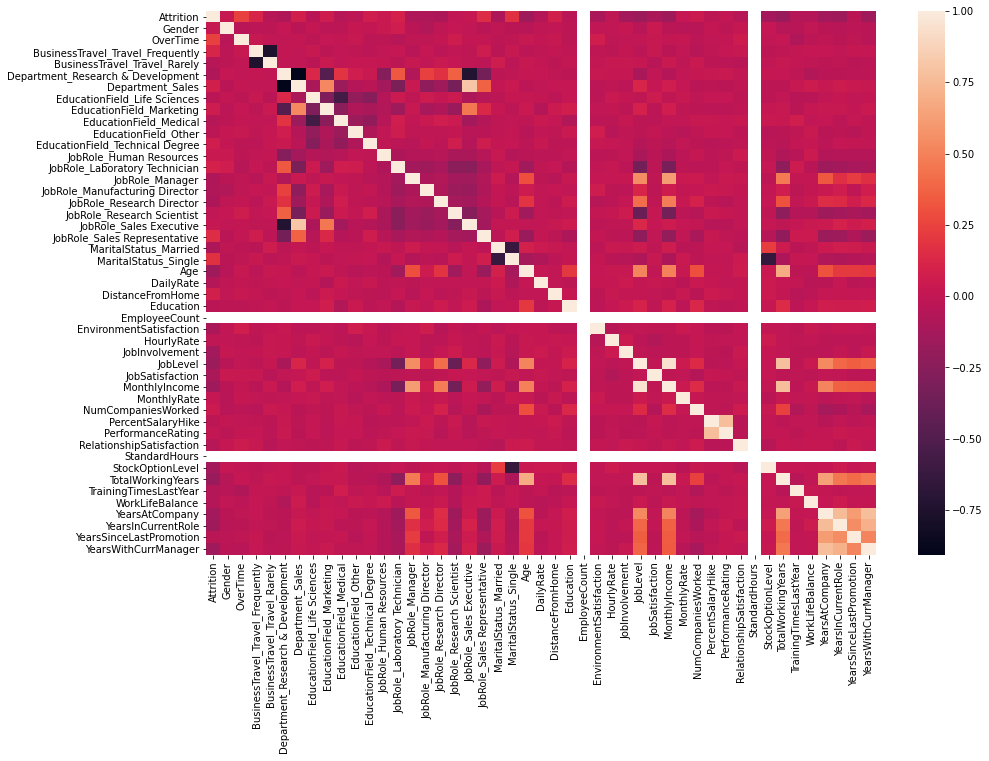

In [ ]:
corr_matrix = data.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix)
plt.show()

In [ ]:
cols_to_melt = corr_matrix.columns
corr_matrix = corr_matrix.reset_index()

In [ ]:
corr_matrix_melted = corr_matrix.melt( id_vars='index', value_vars=cols_to_melt)
corr_matrix_melted = corr_matrix_melted[corr_matrix_melted['index'] != corr_matrix_melted['variable']]
corrlations_above_threshold = corr_matrix_melted[corr_matrix_melted.value.abs() > .8]
columns_to_drop = corrlations_above_threshold['index'].to_list()
columns_to_drop

['Department_Sales',
 'Department_Research & Development',
 'JobRole_Sales Executive',
 'Department_Sales',
 'MonthlyIncome',
 'JobLevel']

In [ ]:
data.drop(columns=columns_to_drop, inplace=True)

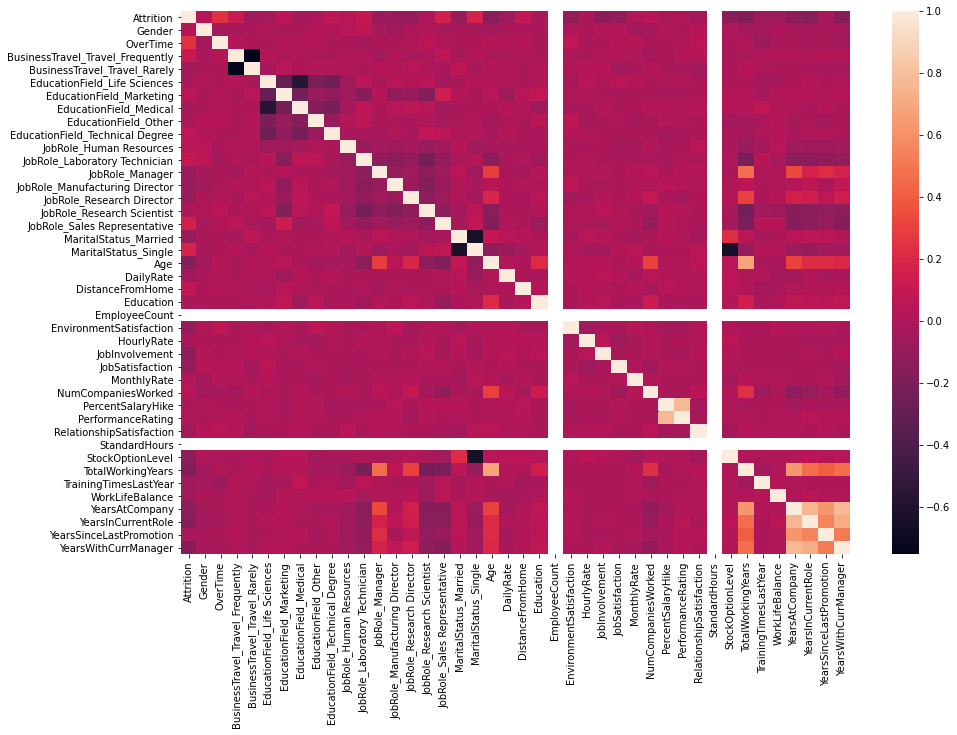

In [ ]:
corr_matrix = data.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix)
plt.show()

# Unbalanced data

In [ ]:
data.Attrition.value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

In [ ]:
positive_labels = data[data.Attrition==1]
num_positive_labels = positive_labels.shape[0]
num_positive_labels

237

In [ ]:
negative_labels = data[data.Attrition==0].sample(num_positive_labels)
negative_labels.shape

(237, 42)

In [ ]:
balanced_data =  positive_labels.append(negative_labels)

# Splitting data into test splits

In [ ]:
balanced_data.head()

,Attrition,Gender,OverTime,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.446350,0.742527,-1.010909,-0.891688,0.0,-0.660531,1.383138,0.379672,1.153254,0.726020,2.125136,-1.150554,-0.426230,-1.584178,0.0,-0.932014,-0.421642,-2.171982,-2.493820,-0.164613,-0.063296,-0.679146,0.245834
2,1,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0.008343,1.414363,-0.887515,-0.891688,0.0,1.169781,1.284725,-1.026167,0.246200,-1.674841,1.324226,-0.057267,-0.426230,-0.658973,0.0,-0.932014,-0.550208,0.155707,0.338096,-1.144294,-1.167687,-0.679146,-1.155935
14,1,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,-0.977174,-1.734097,1.827158,0.085049,0.0,0.254625,-0.781948,-1.026167,0.246200,-0.191993,0.923771,-0.330589,-0.426230,-0.658973,0.0,-0.932014,-0.678774,0.931603,0.338096,-0.491174,-0.615492,-0.679146,-0.314873
21,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,-0.101159,1.030102,-0.023755,1.061787,0.0,0.254625,0.792660,-1.026167,-1.567907,-1.029758,1.724681,2.129306,2.346151,-0.658973,0.0,-0.932014,-0.164511,0.931603,0.338096,-0.327893,-0.339394,-0.679146,-0.314873
24,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,-0.320163,-0.256552,-0.393938,-1.868426,0.0,-0.660531,0.841867,0.379672,-1.567907,0.391954,-0.277594,-1.150554,-0.426230,0.266233,0.0,-0.932014,-0.421642,-0.620189,0.338096,-0.491174,-0.615492,-0.368715,-0.314873


In [ ]:
y = balanced_data.pop('Attrition')
X = balanced_data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [ ]:
X_train.head()

,Gender,OverTime,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1353,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,-0.320163,0.407848,0.840004,1.061787,0.0,1.169781,0.940280,-2.432006,-1.567907,0.020645,-0.678049,2.129306,2.346151,-0.658973,0.0,0.241988,-0.807339,-0.620189,0.338096,-0.327893,-0.615492,0.252146,-1.155935
86,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,-1.524683,-0.648250,-0.887515,-1.868426,0.0,0.254625,-0.191470,0.379672,-1.567907,-0.673908,0.122861,-0.603911,-0.426230,0.266233,0.0,0.241988,-1.064470,0.155707,0.338096,-1.144294,-1.167687,-0.679146,-1.155935
980,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,-0.648668,-0.246635,-0.887515,0.085049,0.0,0.254625,1.186312,-1.026167,1.153254,-0.341670,1.724681,-0.330589,-0.426230,0.266233,0.0,-0.932014,-1.064470,0.155707,1.754054,-0.981014,-1.167687,-0.679146,-1.155935
564,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0.884358,0.375619,-0.887515,-0.891688,0.0,-0.660531,-0.978775,-2.432006,0.246200,-0.270556,-1.078504,-0.603911,-0.426230,-1.584178,0.0,-0.932014,-0.293077,0.155707,0.338096,0.161947,0.764998,0.252146,-0.875581
762,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,-1.196177,-1.141591,-0.887515,0.085049,0.0,-1.575686,-0.437503,0.379672,-1.567907,0.145164,1.324226,-0.330589,-0.426230,-0.658973,0.0,0.241988,-0.678774,-0.620189,0.338096,-0.654454,-0.615492,-0.368715,-0.595227


In [ ]:
# fit a model
clf = LogisticRegression(penalty='l2').fit(X_train, y_train)
# predict probabilities
predictions = clf.predict_proba(X_test)[:, 1]

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
# Confusion matrix

pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,41,14
1,13,51


In [ ]:
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,0,1,All
Actual,,,
0,41,14,55
1,13,51,64
All,54,65,119


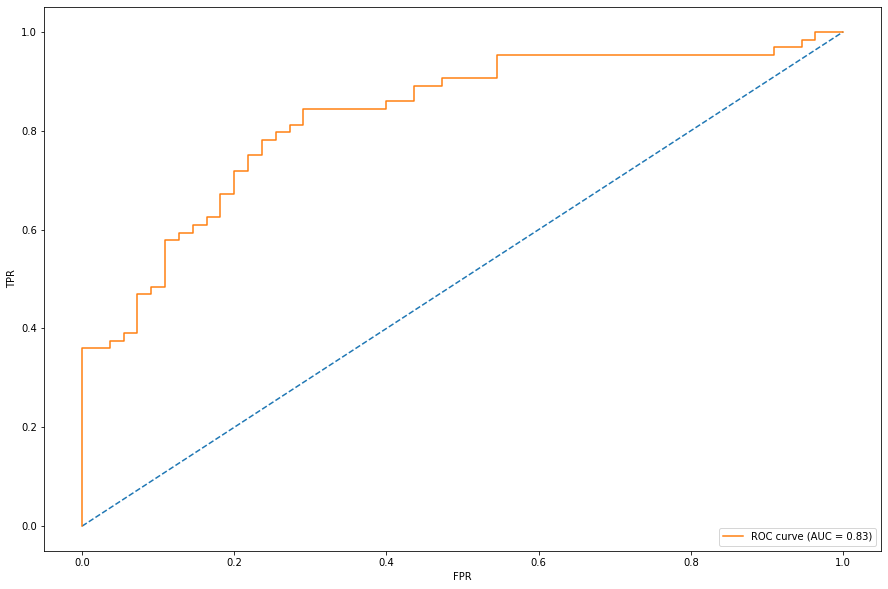

In [ ]:
# calculate scores
auc = roc_auc_score(y_test, predictions)

# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, predictions)

plt.figure(figsize=(15, 10))
# plot horizontal line 
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()

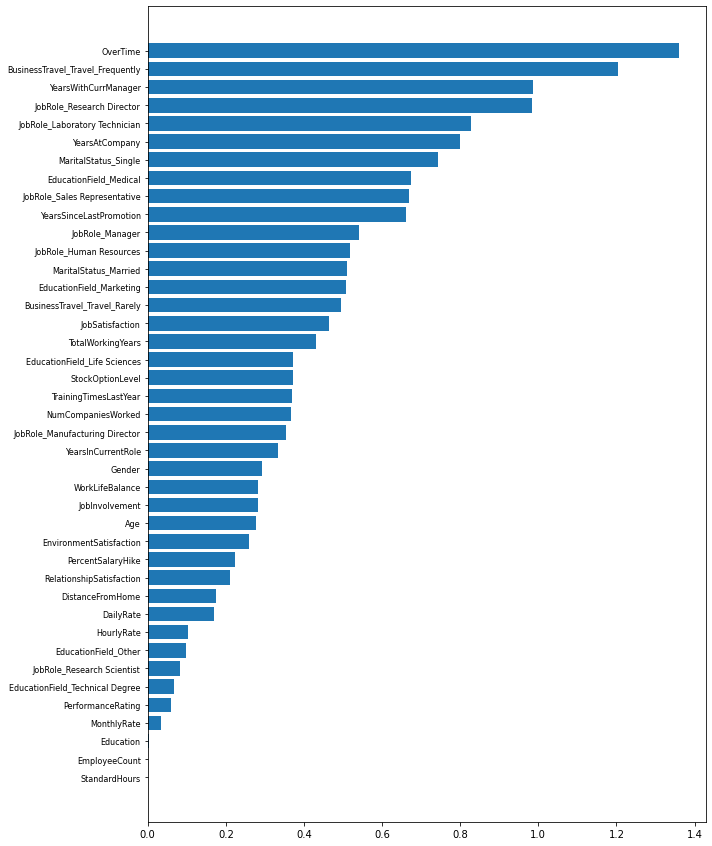

In [ ]:
feature_importance = abs(clf.coef_[0])
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10, 15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)

plt.show()